  0%|          | 0/201 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
  0%|          | 1/201 [00:51<2:50:38, 51.19s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
  1%|          | 2/201 [01:46<2:58:05, 53.69s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential m

✅ Saved: daily_to_cumulative_predictions.csv


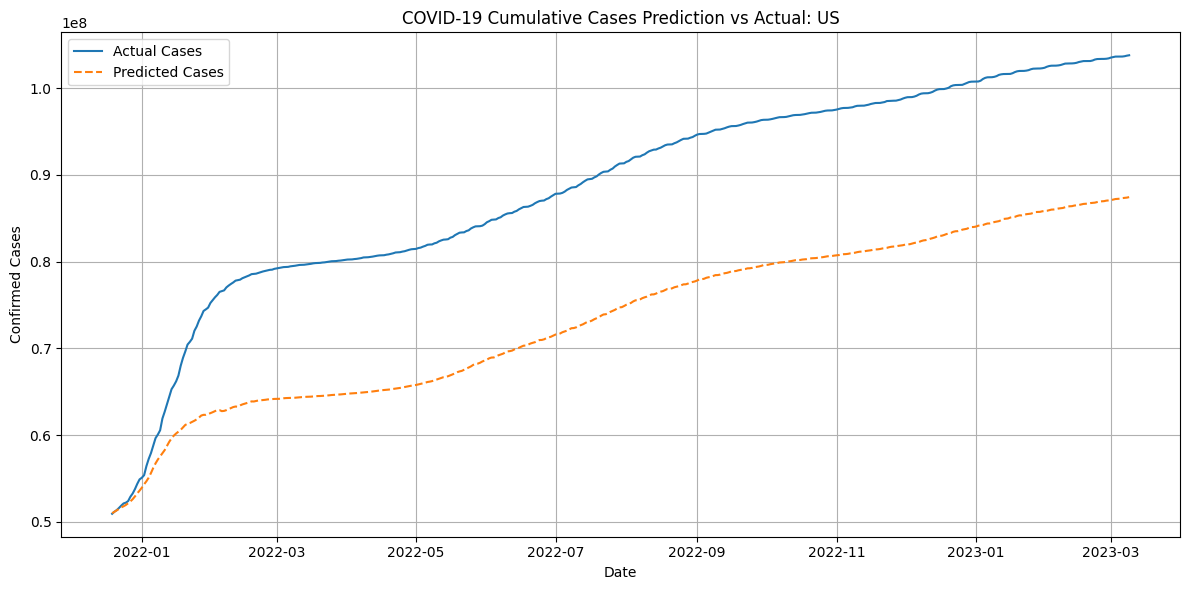

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/confirmed_long_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Country/Region', 'Date'], inplace=True)

# Compute daily cases instead of cumulative
df['Daily_Confirmed'] = df.groupby('Country/Region')['Confirmed'].diff().fillna(0)

# Store predictions
all_predictions = []

# Function to create LSTM input sequences
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Loop through each country
countries = df['Country/Region'].unique()

for country in tqdm(countries):
    country_df = df[df['Country/Region'] == country]
    daily_cases = country_df[['Daily_Confirmed']].values

    if len(daily_cases) < 40:
        continue

    scaler = MinMaxScaler()
    daily_scaled = scaler.fit_transform(daily_cases)

    # Create sequences
    X, y = create_sequences(daily_scaled, window=30)
    if len(X) == 0:
        continue

    split = int(len(X) * 0.6)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Model
    model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(30, 1)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
     ])
  
    model.compile(optimizer=Adam(learning_rate= 0.001), loss='huber')
    
    callbacks = [
    EarlyStopping(patience=15),
    ReduceLROnPlateau(factor=0.2, patience=5)
    ]
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    
    # Predict daily cases on test
    y_pred = model.predict(X_test, verbose=0)
    y_pred_actual = scaler.inverse_transform(y_pred).flatten()
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Reconstruct predicted cumulative cases
    start_cumulative = country_df['Confirmed'].iloc[-len(y_test_actual)-1]
    predicted_cumulative = np.cumsum(y_pred_actual) + start_cumulative
    actual_cumulative = country_df['Confirmed'].iloc[-len(y_test_actual):].values

    test_dates = country_df['Date'].iloc[-len(y_test_actual):].values

    for date, actual, predicted in zip(test_dates, actual_cumulative, predicted_cumulative):
        all_predictions.append({
            'Country/Region': country,
            'Date': date,
            'Actual_Cases': actual,
            'Predicted_Cases': predicted
        })

# Save all predictions to CSV
final_df = pd.DataFrame(all_predictions)
final_df.to_csv("/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions.csv", index=False)
print("✅ Saved: daily_to_cumulative_predictions.csv")

# --- OPTIONAL: Plot for one country ---
plot_country = "US"  # change to any country like 'India', 'Italy', etc.
country_plot_df = final_df[final_df['Country/Region'] == plot_country]

plt.figure(figsize=(12, 6))
plt.plot(country_plot_df['Date'], country_plot_df['Actual_Cases'], label='Actual Cases')
plt.plot(country_plot_df['Date'], country_plot_df['Predicted_Cases'], label='Predicted Cases', linestyle='--')
plt.title(f"COVID-19 Cumulative Cases Prediction vs Actual: {plot_country}")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


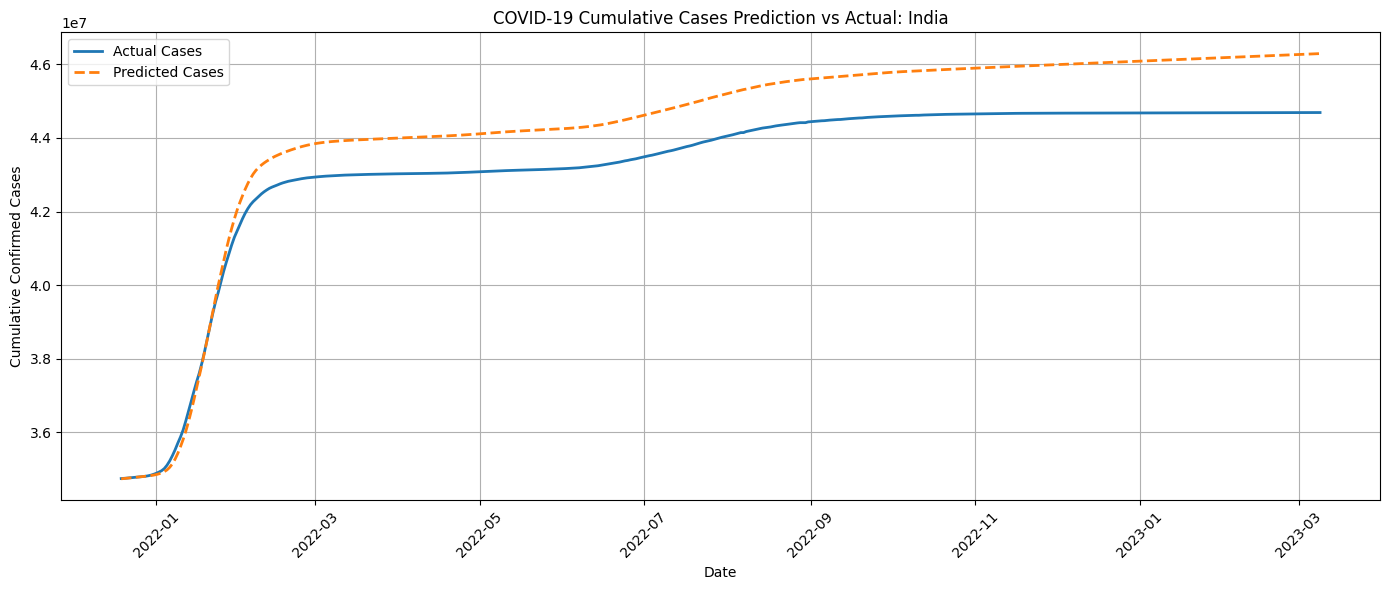

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction data
final_df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions.csv")

# Convert the 'Date' column to datetime format
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Choose country to plot
plot_country = "India"  # You can change this to "India", "Italy", etc.
country_plot_df = final_df[final_df['Country/Region'] == plot_country]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(country_plot_df['Date'], country_plot_df['Actual_Cases'], label='Actual Cases', linewidth=2)
plt.plot(country_plot_df['Date'], country_plot_df['Predicted_Cases'], label='Predicted Cases', linestyle='--', linewidth=2)
plt.title(f"COVID-19 Cumulative Cases Prediction vs Actual: {plot_country}")
plt.xlabel("Date")
plt.ylabel("Cumulative Confirmed Cases")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/p6/bs_y3xtn0mdc96blxc86b9b40000gn/T/ipykernel_31580/1099140493.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Daily_Confirmed'] = country_data['Confirmed'].diff().fillna(0)


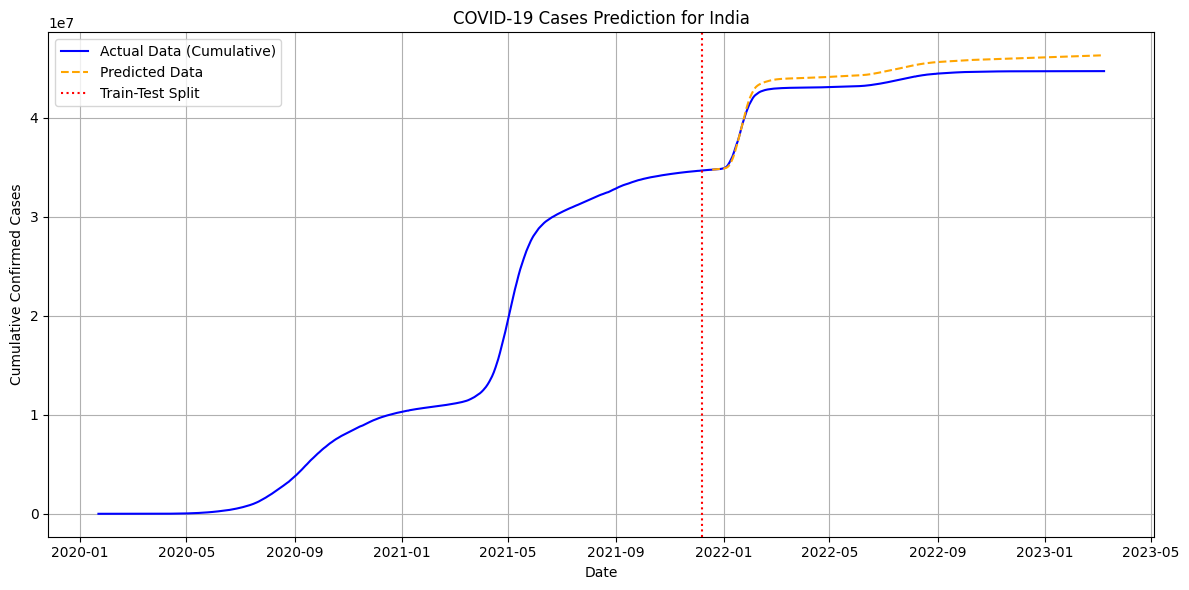

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load actual data
actual_data = pd.read_csv('/Users/jayanthmanthrigalla/Downloads/confirmed_long_cleaned.csv')
actual_data['Date'] = pd.to_datetime(actual_data['Date'])
actual_data.sort_values(['Country/Region', 'Date'], inplace=True)

# Filter for a specific country (e.g., India)
country = 'India'
country_data = actual_data[actual_data['Country/Region'] == country]

# Compute daily confirmed cases
country_data['Daily_Confirmed'] = country_data['Confirmed'].diff().fillna(0)

# Load predictions
predictions = pd.read_csv('/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions.csv')
predictions['Date'] = pd.to_datetime(predictions['Date'])

# Filter predictions for the same country
country_predictions = predictions[predictions['Country/Region'] == country]

# Extract training data (assuming 60% split)
split_index = int(len(country_data) * 0.6)
training_data = country_data.iloc[:split_index]

# Plot actual data including training and predicted data
plt.figure(figsize=(12, 6))
plt.plot(country_data['Date'], country_data['Confirmed'], label='Actual Data (Cumulative)', color='blue')
plt.plot(country_predictions['Date'], country_predictions['Predicted_Cases'], label='Predicted Data', linestyle='--', color='orange')
plt.axvline(country_data['Date'].iloc[split_index], color='red', linestyle=':', label='Train-Test Split')
plt.title(f"COVID-19 Cases Prediction for {country}")
plt.xlabel("Date")
plt.ylabel("Cumulative Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# Load cumulative predictions
cumulative_predictions_path = "/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions.csv"
cumulative_predictions = pd.read_csv(cumulative_predictions_path)

# Ensure the Date column is in datetime format
cumulative_predictions['Date'] = pd.to_datetime(cumulative_predictions['Date'])

# Sort by Country/Region and Date to ensure proper order
cumulative_predictions.sort_values(['Country/Region', 'Date'], inplace=True)

# Calculate daily cases from cumulative predictions
cumulative_predictions['Predicted_Daily_Cases'] = cumulative_predictions.groupby('Country/Region')['Predicted_Cases'].diff().fillna(0)

# Save the updated DataFrame with daily cases
output_path = "/Users/jayanthmanthrigalla/Downloads/daily_cases_from_cumulative_predictions.csv"
cumulative_predictions.to_csv(output_path, index=False)
print(f"✅ Saved daily cases to: {output_path}")


✅ Saved daily cases to: /Users/jayanthmanthrigalla/Downloads/daily_cases_from_cumulative_predictions.csv


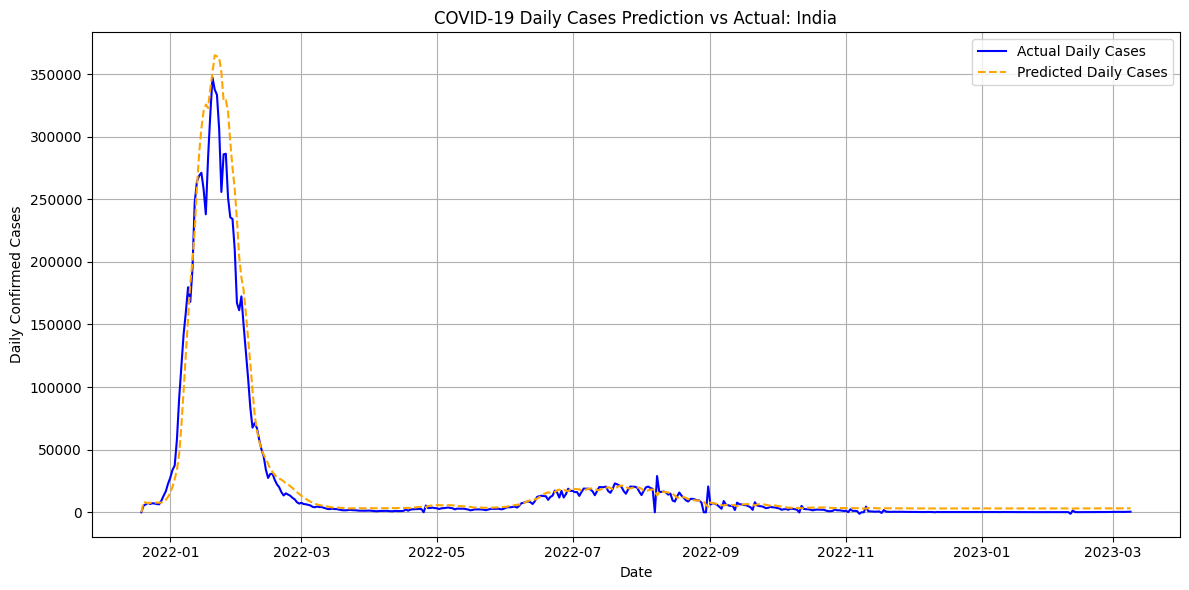

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cumulative predictions
cumulative_predictions_path = "/Users/jayanthmanthrigalla/Downloads/daily_to_cumulative_predictions.csv"
cumulative_predictions = pd.read_csv(cumulative_predictions_path)

# Ensure the Date column is in datetime format
cumulative_predictions['Date'] = pd.to_datetime(cumulative_predictions['Date'])

# Sort by Country/Region and Date to ensure proper order
cumulative_predictions.sort_values(['Country/Region', 'Date'], inplace=True)

# Calculate daily cases for both actual and predicted cumulative cases
cumulative_predictions['Actual_Daily_Cases'] = cumulative_predictions.groupby('Country/Region')['Actual_Cases'].diff().fillna(0)
cumulative_predictions['Predicted_Daily_Cases'] = cumulative_predictions.groupby('Country/Region')['Predicted_Cases'].diff().fillna(0)

# --- Plot Daily Cases for One Country ---
plot_country = "India"  # Change to any country like 'US', 'Italy', etc.
country_data = cumulative_predictions[cumulative_predictions['Country/Region'] == plot_country]

plt.figure(figsize=(12, 6))
plt.plot(country_data['Date'], country_data['Actual_Daily_Cases'], label='Actual Daily Cases', color='blue')
plt.plot(country_data['Date'], country_data['Predicted_Daily_Cases'], label='Predicted Daily Cases', linestyle='--', color='orange')
plt.title(f"COVID-19 Daily Cases Prediction vs Actual: {plot_country}")
plt.xlabel("Date")
plt.ylabel("Daily Confirmed Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Model Test

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Extract actual and predicted daily cases
actual_daily = country_data['Actual_Daily_Cases'].values
predicted_daily = country_data['Predicted_Daily_Cases'].values

# Calculate metrics
mae = mean_absolute_error(actual_daily, predicted_daily)
mse = mean_squared_error(actual_daily, predicted_daily)
r2 = r2_score(actual_daily, predicted_daily)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 243.86
MSE: 266889.67
R²: 0.8776


In [6]:


# Calculate daily cases for both actual and predicted cumulative cases
cumulative_predictions['Actual_Daily_Cases'] = cumulative_predictions.groupby('Country/Region')['Actual_Cases'].diff().fillna(0)
cumulative_predictions['Predicted_Daily_Cases'] = cumulative_predictions.groupby('Country/Region')['Predicted_Cases'].diff().fillna(0)

# Prepare a list to store metrics for each country
metrics = []

# Loop through each country and calculate metrics
for country, group in cumulative_predictions.groupby('Country/Region'):
    actual = group['Actual_Daily_Cases'].values
    predicted = group['Predicted_Daily_Cases'].values

    # Skip countries with too few data points
    if len(actual) < 2:
        continue

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    metrics.append({
        'Country/Region': country,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    })

# Create a DataFrame with all metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Optionally, save to CSV
metrics_df.to_csv("/Users/jayanthmanthrigalla/Downloads/daily_case_metrics_by_country.csv", index=False)
print("✅ Saved: daily_case_metrics_by_country.csv")


           Country/Region         MAE           MSE        R2
0             Afghanistan   62.273241  9.898555e+03  0.489426
1                 Albania  149.284352  1.430913e+05  0.580437
2                 Algeria   24.103812  6.243617e+03  0.951004
3                 Andorra   91.229641  3.545242e+04  0.144261
4                  Angola  138.193389  1.435269e+05 -0.159723
..                    ...         ...           ...       ...
196    West Bank and Gaza  647.688994  4.365197e+06  0.033489
197  Winter Olympics 2022    1.173605  4.048334e+01  0.000757
198                 Yemen    6.211211  4.047284e+02  0.064692
199                Zambia  137.399595  5.993956e+04  0.898236
200              Zimbabwe  162.630767  1.362635e+05  0.206116

[201 rows x 4 columns]
✅ Saved: daily_case_metrics_by_country.csv


### MAE Graph

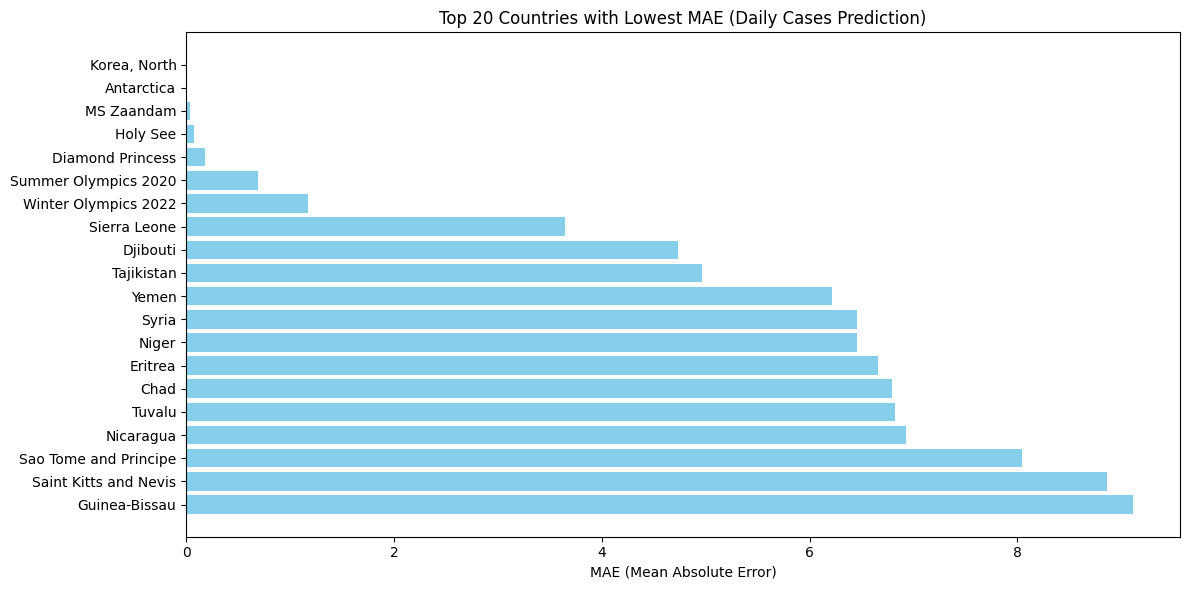

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics DataFrame
metrics_df = pd.read_csv("/Users/jayanthmanthrigalla/Downloads/daily_case_metrics_by_country.csv")

# Sort by MAE (ascending) and select top 20
top_mae = metrics_df.sort_values('MAE').head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_mae['Country/Region'], top_mae['MAE'], color='skyblue')
plt.xlabel('MAE (Mean Absolute Error)')
plt.title('Top 20 Countries with Lowest MAE (Daily Cases Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### R2 Graph

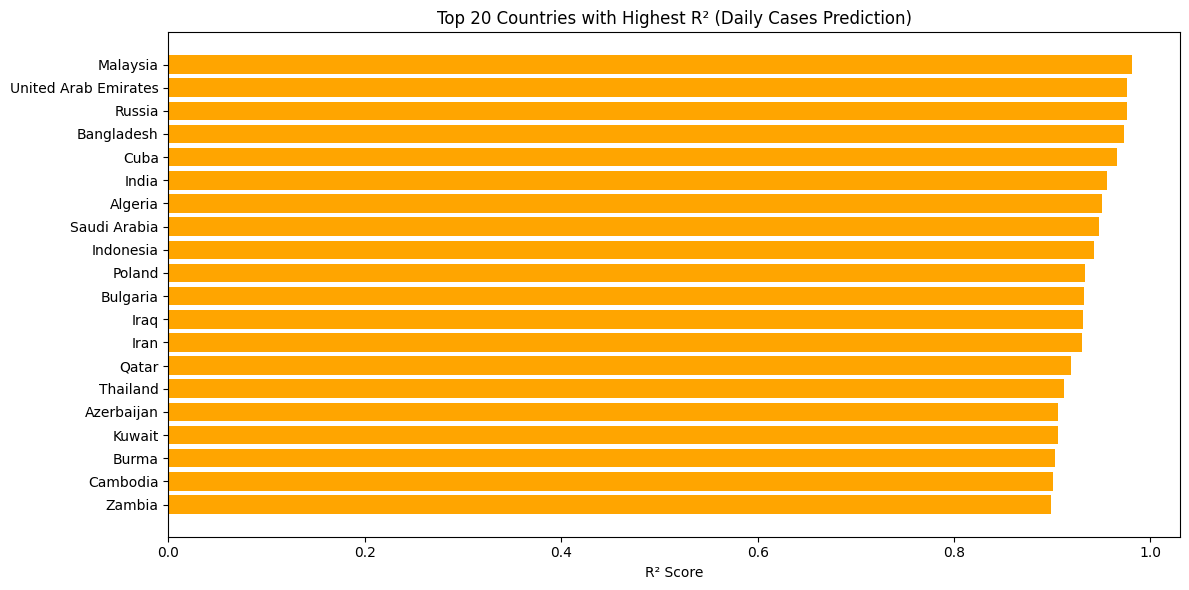

In [8]:
# Sort by R2 (descending) and select top 20
top_r2 = metrics_df.sort_values('R2', ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_r2['Country/Region'], top_r2['R2'], color='orange')
plt.xlabel('R² Score')
plt.title('Top 20 Countries with Highest R² (Daily Cases Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### MSE Graph

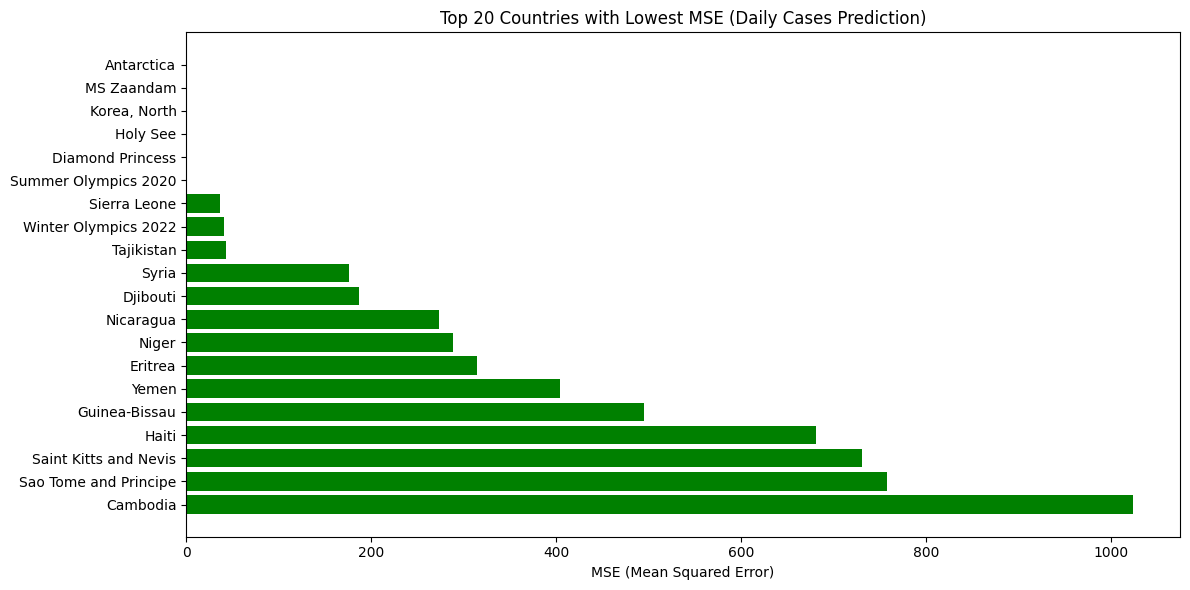

In [9]:
# Sort by MSE (ascending) and select top 20
top_mse = metrics_df.sort_values('MSE').head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_mse['Country/Region'], top_mse['MSE'], color='green')
plt.xlabel('MSE (Mean Squared Error)')
plt.title('Top 20 Countries with Lowest MSE (Daily Cases Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
